In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [2]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

0.26.0


In [6]:
##GEORGIA GA
##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Yearly data/Flats' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

##Bands and indices

df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') ##make sure no other sensors are being used

df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4'])) ##ndvi conditional based on whether sensor is Landsat-5 or 8

df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])

df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

##DAYMET data added - yearly averages
##PC:
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)

dm['ident'] = dm['Latitude']/dm['Longitude']

##Seasonal averages: growing season (defined as between 3/1 and 10/31)
path3 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Growing season' 
all_files3 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files3:
    dm2 = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm2)

dm2 = pd.concat(li, axis=0, ignore_index=True)

dm2['ident'] = dm2['Latitude']/dm2['Longitude']

dm2 = dm2.rename(
    columns={
        'dayl': 'sn_dayl', 'prcp': 'sn_prcp', 'srad': 'sn_srad','tmax': 'sn_tmax','tmin': 'sn_tmin','vp': 'sn_vp'
    }
)

##Loading elevation data
elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Point_elevation/DEM_vals_10m.csv')

elev_10m.rename(columns={'first':'Elevation'}, inplace=True)

## drop rows which have same lat and long and keep latest entry
dfx = elev_10m.drop_duplicates(
  subset = ['Latitude', 'Longitude'],
  keep = 'last').reset_index(drop = True)

dfx = dfx[['Elevation', 'Latitude', 'Longitude']]
dfx['ident'] = dfx['Latitude']/dfx['Longitude']

df['ident'] = df['Latitude']/df['Longitude'] 

##Merging elevation point data with band dataset prior to model development
df0 = pd.merge(df, dfx, on = 'ident')
df0_sn = pd.merge(df0, dm2)
df1 = pd.merge(df0_sn, dm)

df1 = df1[df1['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['prcp'].notna()] ##CAREFUL; added 7/11/22
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here
df1 = df1[(df1['flats'] < 0.1) & (df1['flats'] > -0.1)] ##Increases NRMSE by 0.003, but seems to be a better fit

ga_df1 = df1.copy()

ga_df1['Date'] = pd.to_datetime(ga_df1.Date, format='%m/%d/%Y')
ga_df1['DOY'] = ga_df1['Date'].dt.strftime('%j') ##Add day of year (DOY) to dataset

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

xargs=ga_df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b','wdrvi5', 'savi', 
        'Elevation', 'tmax', 'tmin', 'sn_tmax', 'sn_tmin', 'DOY' 
    ]
]

#removed: 'nd_r_g','dayl','sn_prcp', 'sn_dayl', 'sn_srad', 'sn_vp', 'vp', 'srad', 'prcp'

yargs=df1['Plant_Biomass'] 

size_x = 0.2
seed = 0
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test - NOT NEEDED IN IMPLEMENTATION?
# # Pipeline example:
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

ModuleNotFoundError: No module named 'xgboost'

In [7]:
##Virginia VA

##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Yearly point extraction data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') 
df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4']))
df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

df = df.drop(columns=['latitude','longitude'])
df['ident'] = df['Latitude'] / df['Longitude'] + df['Year'] 

##DAYMET data
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/VA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)
dm.rename(columns={'site_id':'siteName'}, inplace=True)
dm = dm.drop(columns=['latitude','longitude'])
dm['ident'] = dm['Latitude'] / dm['Longitude'] + dm['Year']

##Seasonal averages: growing season (defined as between 3/1 and 10/31)
path3 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/VA/Growing season' 
all_files3 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files3:
    dm2 = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm2)

dm2 = pd.concat(li, axis=0, ignore_index=True)

dm2['ident'] = dm2['Latitude']/dm2['Longitude']

dm2 = dm2.rename(columns={'dayl': 'sn_dayl', 'prcp': 'sn_prcp', 'srad': 'sn_srad', \
                        'tmax': 'sn_tmax','tmin': 'sn_tmin','vp': 'sn_vp', 'swe': 'sn_swe'})

##TBD: Seasonal averages/growing season (defined as between 3/1 and 10/31)

##Loading elevation data
elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Point elevation/VA_DEM_vals_10m.csv')
elev_10m.rename(columns={'first':'Elevation'}, inplace=True)
elev_10m.rename(columns={'site_id':'siteName'}, inplace=True)
elev_10m['ident'] = elev_10m['Latitude'] / elev_10m['Longitude'] + elev_10m['Year']

##Merging daymet, elevation, and flats data
df['dropident'] = df['Latitude']/df['Longitude']*df['Year']+df['liveMass']
dm['dropident'] = dm['Latitude']/dm['Longitude']*dm['Year']+dm['liveMass']
dm2['dropident'] = dm2['Latitude']/dm2['Longitude']*dm2['Year']+dm2['liveMass']
elev_10m['dropident'] = elev_10m['Latitude']/elev_10m['Longitude']*elev_10m['Year']+elev_10m['liveMass']

dm0 = pd.merge(dm, dm2, on = ['dropident'], how = 'left')

dm0 = dm0.drop(dm0.loc[:, 'system:index_y':'ident_y'].columns, axis=1)

dm0.columns = [
    'dayl','prcp','srad','swe','tmax','tmin','vp','system:index','marshName','siteName', 'Latitude', 
    'Code', 'Longitude', 'monitoringPurpose', 'Replicate','Year', 'speciesName','locationID','liveMass','Transect','ident',
    'dropident', 'sn_dayl', 'sn_prcp', 'sn_srad', 'sn_swe', 'sn_tmax', 'sn_tmin', 'sn_vp'
]

##Merge daymet with remote sensing data:

df0 = pd.merge(df, dm0, on = ['dropident'], how = 'left')

df0['dropident'] = df0['Latitude_x']/df0['Longitude_x']*df0['Year_x']+df0['liveMass_x']
print(len(df0['dropident']))
df0 = df0.drop_duplicates(
  subset = ['dropident'],
  keep = 'last').reset_index(drop = True)
print(len(df0['dropident']))

##Merge with elevation
df1 = pd.merge(df0, elev_10m, on = ['dropident'], how = 'left')

df1['dropident'] = df1['Latitude_x']/df1['Longitude_x']*df1['Year_x']+df1['liveMass_x']
print(len(df1['dropident']))
df1 = df1.drop_duplicates(
  subset = ['dropident'],
  keep = 'last').reset_index(drop = True)
print(len(df1['dropident']))

##THIS NEEDS TO BE 0
print('df0 biomass diff is: '+str(sum(df0['liveMass_x'] - df0['liveMass_y'])))
print('df1 biomass diff (x-y) is: '+str(sum(df1['liveMass_x'] - df1['liveMass_y'])))
print('df1 biomass diff (x-z) is: '+str(sum(df1['liveMass_x'] - df1['liveMass'])))
# df1.rename(columns={'liveMass_x':'liveMass'}, inplace=True)

print("biomass measurements: " + str(len(df1['liveMass'])))
print(len(df1['Elevation'].unique()))

df1 = df1.drop(columns = ['latitude', 'longitude']) ##lower case ones are the older values

##Some more data massaging
df1 = df1[df1['ndvi'].notna()]
df1 = df1[df1['liveMass'].notna()]
df1 = df1[df1['Latitude'].notna()]
df1 = df1[(df1['flats'] < 0.1)] ##Double check

##Group df1 and average (midpoint) the replicates (a/b)
df_temp=df1.copy()

df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(
    {
        'liveMass':[np.mean, np.size],'ndvi':[np.mean],'nd_swir2_r':[np.mean],'nd_swir2_nir':[np.mean],'nd_g_b':[np.mean],
        'nd_r_g':[np.mean],'wdrvi5':[np.mean],'savi':[np.mean],'Elevation':[np.mean],'prcp':[np.mean],'dayl':[np.mean],
        'tmax':[np.mean],'tmin':[np.mean],'srad':[np.mean],'vp':[np.mean], 'sn_prcp':[np.mean],'sn_dayl':[np.mean],
        'sn_tmax':[np.mean],'sn_tmin':[np.mean],'sn_srad':[np.mean],'sn_vp':[np.mean], 'collectDate':'first'
    }
)

df_temp.columns = [
    'Year','locationID','Transect','Latitude','Longitude','liveMass','N','ndvi','nd_swir2_r','nd_swir2_nir', 'nd_g_b', 
    'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl','tmax','tmin','srad','vp','sn_prcp', 'sn_dayl','sn_tmax','sn_tmin',
    'sn_srad','sn_vp', 'collectDate'
]

# display(df_temp)

##Machine learning
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

df1 = df_temp.copy() ##Therein the rub! COMMENT OUT if you do not want to group replicates
va_df1 = df_temp.copy()

va_df1['DOY'] = pd.to_datetime(va_df1['collectDate']).apply(lambda x: x.strftime('%j')if not pd.isnull(x) else '')
va_df1 = va_df1.drop(df1.index[0:205]) ##Add day of year (DOY) to dataset, but loses data

print("biomass measurements: " + str(len(df1['liveMass'])))

xva=va_df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl', 'tmax', 'tmin',
        'srad', 'vp', 'sn_prcp', 'sn_dayl','sn_tmax','sn_tmin','sn_srad','sn_vp', 'DOY'
    ]
]

yva=va_df1['liveMass'] 

size_x = 0.2
seed = 3
xva_train, xva_test, yva_train, yva_test = train_test_split(xva, yva, test_size=size_x, random_state = seed) 
## 80% training and 20% test

VApipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
VApipe.fit(xva_train, yva_train)
va_pred=VApipe.predict(xva_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yva_test, va_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yva_test, va_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yva_test, va_pred)))
r_square = metrics.r2_score(yva_test, va_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(VApipe.score(xva_test, yva_test)))
print('training r2 is: ' + str(VApipe.score(xva_train, yva_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yva_test, va_pred))/np.ptp(yva_test)))

# Mean
print('MEAN BASELINE:')
va_pred_mean = [np.mean(yva_train)] * len(yva_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yva_test, va_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yva_test, va_pred_mean)))

1972
1846
1864
1846
df0 biomass diff is: 0.0
df1 biomass diff (x-y) is: 0.0
df1 biomass diff (x-z) is: 0.0
biomass measurements: 1846
153


C:\Users\arj26323\AppData\Local\Temp\ipykernel_3400\4093856654.py:130: FutureWarning: The provided callable <function mean at 0x0000019619CDD090> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(
C:\Users\arj26323\AppData\Local\Temp\ipykernel_3400\4093856654.py:130: FutureWarning: The provided callable <function mean at 0x0000019619CDD090> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(


ModuleNotFoundError: No module named 'xgboost'

,B1,B2,B3,B4,B5,B6,B7,flats,system:index,Site,...,srad,tmax,tmin,vp,DOY,lter,locationID,Transect,N,collectDate
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0.019625,0.0,1.0,...,342.593597,25.048056,14.132274,1776.901489,285,GA,NaN,NaN,NaN,NaN
1,0.0263,0.0404,0.0351,0.0745,0.0697,0.2883,0.0448,0.033653,0.0,1.0,...,342.510712,25.575659,14.795082,1762.035522,290,GA,NaN,NaN,NaN,NaN
3,0.0344,0.0429,0.0374,0.0798,0.0649,0.2951,0.0362,0.095547,0.0,1.0,...,340.148438,25.406548,14.338548,1778.461426,299,GA,NaN,NaN,NaN,NaN
4,0.0240,0.0361,0.0321,0.0872,0.0559,0.2947,0.0309,0.049471,0.0,1.0,...,338.359924,25.079752,14.206429,1799.670776,297,GA,NaN,NaN,NaN,NaN
5,0.0598,0.0626,0.0610,0.1112,0.0979,0.2968,0.0613,0.004838,0.0,1.0,...,351.314453,26.066071,14.187940,1683.812134,289,GA,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,307.891052,20.562885,11.365109,1535.228271,226,VA,3.0,A,2.0,2017-08-14
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,308.119415,20.968325,11.728791,1573.322876,226,VA,3.0,B,2.0,2017-08-14
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,310.027924,20.746950,11.474368,1548.789673,226,VA,3.0,B,2.0,2017-08-14
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,307.995300,21.011868,11.759917,1576.207886,226,VA,3.0,C,2.0,2017-08-14


Mean Absolute Error: 263.69421327306327
Mean Squared Error: 145674.22128368265
Root Mean Squared Error: 381.67292448336264
The r squared is: 0.47755850040596914
0.47755850040596914
testing r2 is: 0.47755850040596914
training r2 is: 0.8954486528185714
NRMSE is: 0.11228739034753092
MEAN BASELINE:
Mean Absolute Error: 358.5157547360355
Root Mean Squared Error: 528.0858835707412


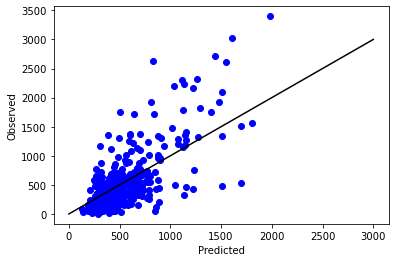

test data correlation coefficient is: 0.7008222851853717
train data correlation coefficient is: 0.9622448828393498


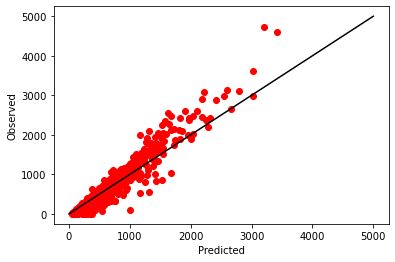

In [4]:
##Combining the datasets

ga_df1.rename(columns={'Plant_Biomass':'liveMass'}, inplace=True)

ga_df1['lter'] = 'GA'
va_df1['lter'] = 'VA'

combined_df = pd.concat([ga_df1, va_df1])

display(combined_df)

combined_df = combined_df[combined_df['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
combined_df = combined_df[combined_df['prcp'].notna()] ##CAREFUL; added 7/11/22

# from sklearn.model_selection import train_test_split
# from numpy import loadtxt
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score

xcomb=combined_df[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', 'tmax', 'tmin',
        'sn_tmax','sn_tmin'
    ]
]
#removed: 'nd_r_g','dayl','sn_prcp', 'sn_dayl', 'sn_srad', 'sn_vp', 'vp', 'srad', 'prcp'
##DOY!!!

# ##Include lag variables (e.g. lag ndvi), precip, temp, more

ycomb=combined_df['liveMass'] 

size_x = 0.2
seed = 3
xcomb_train, xcomb_test, ycomb_train, ycomb_test = train_test_split(xcomb, ycomb, test_size=size_x, random_state = seed) 
## 80% training and 20% test

# # Pipeline example:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe_comb = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe_comb.fit(xcomb_train, ycomb_train)
comb_pred=pipe_comb.predict(xcomb_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(ycomb_test, comb_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ycomb_test, comb_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ycomb_test, comb_pred)))
r_square = metrics.r2_score(ycomb_test, comb_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe_comb.score(xcomb_test, ycomb_test)))
print('training r2 is: ' + str(pipe_comb.score(xcomb_train, ycomb_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(ycomb_test, comb_pred))/np.ptp(ycomb_test)))

# Mean
print('MEAN BASELINE:')
comb_pred_mean = [np.mean(ycomb_train)] * len(ycomb_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(ycomb_test, comb_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ycomb_test,comb_pred_mean)))

plt.scatter(comb_pred, ycomb_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(ycomb_test, comb_pred)[0, 1]))

train_predcomb = pipe_comb.predict(xcomb_train) ##Not sure if this is the right thing to do here
plt.scatter(train_predcomb, ycomb_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 5000], [0, 5000], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_predcomb, ycomb_train)[0, 1]))


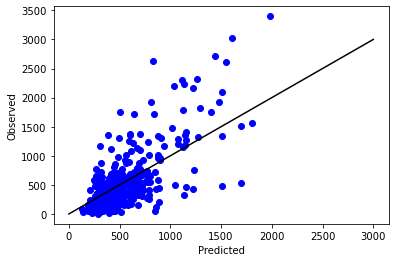

test data correlation coefficient is: 0.7008222851853717


,B1,B2,B3,B4,B5,B6,B7,flats,system:index,Site,...,tmax,tmin,vp,DOY,lter,locationID,Transect,N,collectDate,liveMass_y
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0.019625,0.0,1.0,...,25.048056,14.132274,1776.901489,285,GA,NaN,NaN,NaN,NaN,NaN
1,0.0263,0.0404,0.0351,0.0745,0.0697,0.2883,0.0448,0.033653,0.0,1.0,...,25.575659,14.795082,1762.035522,290,GA,NaN,NaN,NaN,NaN,NaN
3,0.0344,0.0429,0.0374,0.0798,0.0649,0.2951,0.0362,0.095547,0.0,1.0,...,25.406548,14.338548,1778.461426,299,GA,NaN,NaN,NaN,NaN,NaN
4,0.0240,0.0361,0.0321,0.0872,0.0559,0.2947,0.0309,0.049471,0.0,1.0,...,25.079752,14.206429,1799.670776,297,GA,NaN,NaN,NaN,NaN,NaN
5,0.0598,0.0626,0.0610,0.1112,0.0979,0.2968,0.0613,0.004838,0.0,1.0,...,26.066071,14.187940,1683.812134,289,GA,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,0.0193,0.0281,0.0465,0.0441,0.0898,0.0722,0.0404,0.010100,164.0,1.0,...,26.363014,15.224247,1884.204468,300,GA,NaN,NaN,NaN,NaN,NaN
3194,0.0131,0.0272,0.0502,0.0501,0.1254,0.1037,0.0638,0.000209,169.0,1.0,...,25.977501,15.607335,1926.889893,293,GA,NaN,NaN,NaN,NaN,NaN
3195,0.0157,0.0266,0.0453,0.0440,0.1134,0.0851,0.0497,0.000969,176.0,1.0,...,26.363014,15.224247,1884.204468,300,GA,NaN,NaN,NaN,NaN,NaN
3196,0.0169,0.0217,0.0313,0.0259,0.0976,0.0617,0.0319,0.036710,173.0,1.0,...,26.494726,15.637390,1902.391235,287,GA,NaN,NaN,NaN,NaN,NaN


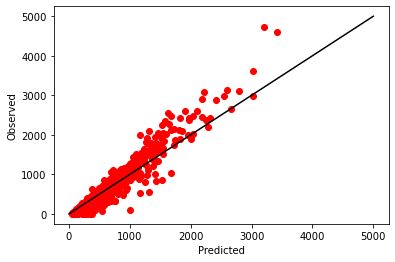

In [5]:
plt.scatter(comb_pred, ycomb_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(ycomb_test, comb_pred)[0, 1]))

train_predcomb = pipe_comb.predict(xcomb_train) ##Not sure if this is the right thing to do here
plt.scatter(train_predcomb, ycomb_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 5000], [0, 5000], 'k-')
plt.show

ycomb_test['preds'] = comb_pred

df_out = pd.merge(combined_df,ycomb_test[['preds']],how = 'left',left_index = True, right_index = True)
df_out



In [6]:
for col in df_out.columns:
    print(col)

B1
B2
B3
B4
B5
B6
B7
flats
system:index
Site
Species_Code
Year
Quadrat_Area
Zone
Plot
Latitude_x
liveMass_x
Sample_Size
Longitude_x
Date
B10
B11
Sensor
ndvi
Blue_band
Green_band
Red_band
NIR_band
SWIR1_band
SWIR2_band
savi
wdrvi5
nd_r_g
nd_g_b
nd_swir2_nir
nd_swir2_r
ident
Elevation
Latitude_y
Longitude_y
sn_dayl
sn_prcp
sn_srad
swe
sn_tmax
sn_tmin
sn_vp
Latitude
Longitude
dayl
prcp
srad
tmax
tmin
vp
DOY
lter
locationID
Transect
N
collectDate
liveMass_y


In [7]:
##k-fold cross validation; random forest

predictors = combined_df[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', 'tmax', 'tmin',
        'sn_tmax', 'sn_tmin'
    ]
]

targets = combined_df['liveMass'] 

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate
from sklearn.datasets import load_boston

X, y = predictors, targets
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

model = pipe_comb
scoring=('r2', 'neg_root_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)
cv_results

##from: https://stackoverflow.com/questions/55270431/how-to-correctly-perform-cross-validation-in-scikit-learn

{'fit_time': array([0.68164539, 0.6876123 , 0.68728232, 0.7247932 , 0.71251726]),
 'score_time': array([0.01562095, 0.01564741, 0.0156219 , 0.01396918, 0.0156219 ]),
 'test_r2': array([0.31794202, 0.37038966, 0.48294678, 0.40962374, 0.36759716]),
 'test_neg_root_mean_squared_error': array([-407.73975409, -426.60505769, -352.09989098, -389.58425142,
        -443.95426444])}

In [8]:
##Comparing with standard empirical model -- just uncomment and run

##sklearn - linear_regressor L1 weights look at these

print(len(xcomb))
print(len(ycomb))

print(xcomb.head())

from sklearn import linear_model
import statsmodels.api as sm

regr = linear_model.LinearRegression()
regr.fit(xcomb, ycomb)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
xcomb = sm.add_constant(xcomb) ##adding a constant
 
model = sm.OLS(ycomb, xcomb).fit()
predictions = model.predict(xcomb) 
 
print_model = model.summary()
print(print_model) ##check model assumptions

1673
1673
       ndvi  nd_swir2_r  nd_swir2_nir    nd_g_b    nd_r_g    wdrvi5      savi  \
0  0.281395   -0.033445     -0.311905  0.052448  0.013115 -0.057314  0.061945   
1  0.359489    0.121402     -0.248952  0.211394 -0.070199  0.029717  0.096949   
3  0.361775   -0.016304     -0.375862  0.109961 -0.068493  0.032342  0.103046   
4  0.461861   -0.019048     -0.476715  0.201331 -0.058651  0.151915  0.133457   
5  0.291521    0.002453     -0.289275  0.022876 -0.012945 -0.046312  0.112020   

   Elevation       tmax       tmin    sn_tmax    sn_tmin  
0   0.489376  25.048056  14.132274  25.048056  14.132274  
1   0.489376  25.575659  14.795082  25.575659  14.795082  
3   0.489376  25.406548  14.338548  25.406548  14.338548  
4   0.489376  25.079752  14.206429  25.079752  14.206429  
5   0.489376  26.066071  14.187940  26.066071  14.187940  
Intercept: 
 1030.971362855176
Coefficients: 
 [  -70.06634789  -283.02436356  -191.53979952    18.45916486
   864.31356535  1570.97342063 -1354.6189

RMSE value for k=  1 is: 514.2185577483567
RMSE value for k=  2 is: 497.8544911660644
RMSE value for k=  3 is: 466.24190945269623
RMSE value for k=  4 is: 449.9459071083198
RMSE value for k=  5 is: 452.3952044671107
RMSE value for k=  6 is: 451.6869981480844
RMSE value for k=  7 is: 453.91347263530724
RMSE value for k=  8 is: 446.6798224208841
RMSE value for k=  9 is: 447.7227386727573
RMSE value for k=  10 is: 438.86286203756134
RMSE value for k=  11 is: 437.2178300327424
RMSE value for k=  12 is: 436.18706664605185
RMSE value for k=  13 is: 436.48911630335357
RMSE value for k=  14 is: 435.6865266977905
RMSE value for k=  15 is: 438.8870169233443
RMSE value for k=  16 is: 438.00487454358074
RMSE value for k=  17 is: 441.43548071736535
RMSE value for k=  18 is: 440.5563413562235
RMSE value for k=  19 is: 438.6854714242662
RMSE value for k=  20 is: 440.1356001010416


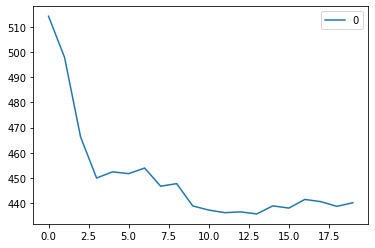

In [9]:
##KNN - be careful of site bias!! Data are spatially clustered based on site, also temporally clustered based on year

##Careful of overlap in variable names!

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

k_xargs=combined_df[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl', 'tmax', 'tmin',
        'srad', 'vp', 'sn_prcp', 'sn_dayl', 'sn_tmax', 'sn_tmin', 'sn_srad', 'sn_vp'
    ]
]

##Include lag variables (e.g. lag ndvi), precip, temp, more

k_yargs=combined_df['liveMass'] 

size_x = 0.2
seed = 0

k_xargs_train, k_xargs_test, k_yargs_train, k_yargs_test = train_test_split(
    k_xargs, k_yargs, test_size=size_x, random_state = seed
)

## 80% training and 20% test

## Feature Scaling - does something weird with k values, what does that mean? Use minmax scaler instead (below), as in example?

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
k_xargs_train = scaler.fit_transform(k_xargs_train)
k_xargs_test = scaler.fit_transform(k_xargs_test)

rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    k_model = neighbors.KNeighborsRegressor(n_neighbors = K)

    k_model.fit(k_xargs_train, k_yargs_train)  #fit the model
    k_pred=k_model.predict(k_xargs_test) #make prediction on test set
    k_error = sqrt(mean_squared_error(k_yargs_test, k_pred)) #calculate rmse
    rmse_val.append(k_error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', k_error)
    
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot() 

k_predict = k_model.predict(k_xargs_test)
##from: https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/

RMSE for KNN is: 438.86286203756134


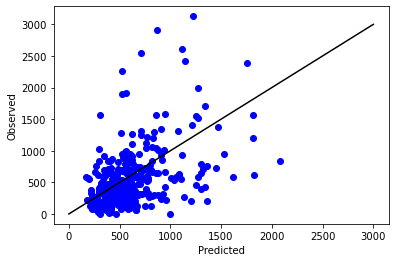

test data correlation coefficient is: 0.44685487007943975
train data correlation coefficient is: 0.6365426437757941


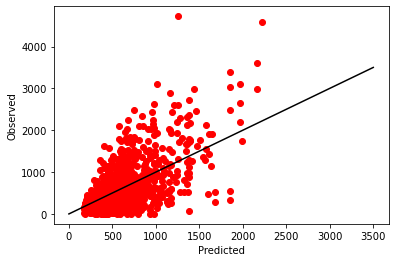

In [10]:
##KNN test results, plotted (careful of variable names overlap)
k_model = neighbors.KNeighborsRegressor(n_neighbors = 10)
k_model.fit(k_xargs_train, k_yargs_train)  #fit the model
k_pred=k_model.predict(k_xargs_test) #make prediction on test set
k_error = sqrt(mean_squared_error(k_yargs_test, k_pred))
print('RMSE for KNN is: ' + str(k_error))

plt.scatter(k_pred, k_yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(k_yargs_test, k_pred)[0, 1]))

k_train_pred = k_model.predict(k_xargs_train) 
plt.scatter(k_train_pred, k_yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3500], [0, 3500], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(k_train_pred, k_yargs_train)[0, 1]))

##Odd that the training data is not better

Mean Absolute Error: 136.41200651497383
Mean Squared Error: 39851.27678333245
Root Mean Squared Error: 199.6278457112946
The r squared is: 0.685183837338539
0.685183837338539
NRMSE is: 0.07846266300006864


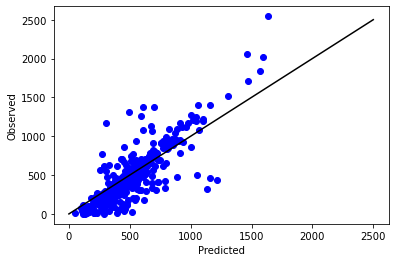

In [11]:
##Running the Combined model on VA data only (obviously combines training and testing - fix this)

##Really, really needs improvement

va_xargs = va_df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b','nd_r_g','wdrvi5', 'savi', 
        'Elevation', 'tmax', 'tmin', 'sn_tmax', 'sn_tmin'
    ]
]

#removed: 'nd_r_g','dayl','sn_prcp', 'sn_dayl', 'sn_srad', 'sn_vp', 'vp', 'srad', 'prcp'

va_yargs = va_df1['liveMass']

va_pred=pipe_comb.predict(va_xargs)

print('Mean Absolute Error:', metrics.mean_absolute_error(va_yargs, va_pred))
print('Mean Squared Error:', metrics.mean_squared_error(va_yargs, va_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(va_yargs, va_pred)))
r_square = metrics.r2_score(va_yargs, va_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(va_yargs, va_pred))/np.ptp(va_yargs)))


plt.scatter(va_pred, va_yargs, color = 'blue')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 2500], [0, 2500], 'k-')
plt.show()

,ndvi,nd_swir2_r,nd_swir2_nir,nd_g_b,nd_r_g,wdrvi5,savi,Elevation,tmax,tmin,sn_tmax,sn_tmin
292,0.667656,0.253955,-0.498167,0.151874,-0.131783,0.430025,0.350832,1.246447,19.114012,10.751703,19.114012,10.751703
339,0.466035,0.056744,-0.420408,0.117998,0.038934,0.157107,0.192419,0.977070,26.490303,16.281868,26.490303,16.281868
5,0.291521,0.002453,-0.289275,0.022876,-0.012945,-0.046312,0.112020,0.489376,26.066071,14.187940,26.066071,14.187940
431,0.510045,0.039387,-0.480306,0.103896,-0.074816,0.212909,0.201855,0.064395,24.954451,14.615027,24.954451,14.615027
381,0.506997,0.072874,-0.450777,0.088983,-0.057613,0.208981,0.206037,0.601948,20.616301,11.838657,20.616301,11.838657
...,...,...,...,...,...,...,...,...,...,...,...,...
1425,0.419672,0.088803,-0.343677,0.103650,-0.032787,0.100381,0.123473,0.762858,26.308792,16.414671,26.308792,16.414671
397,0.428247,0.124240,-0.321091,0.120000,0.014085,0.110719,0.167455,0.627074,20.438192,11.873672,20.438192,11.873672
386,0.302623,0.084803,-0.223558,0.114108,0.007394,-0.034156,0.108106,0.328943,20.804739,12.056520,20.804739,12.056520
797,0.366791,-0.116940,-0.463835,0.155756,-0.000978,0.038118,0.134261,0.042100,25.877171,14.761703,25.877171,14.761703


Mean Absolute Error: 139.6467243728342
Mean Squared Error: 55186.304557916796
Root Mean Squared Error: 234.9176548450899
The r squared is: 0.8225759426353523
0.8225759426353523
NRMSE is: 0.04973991828044725


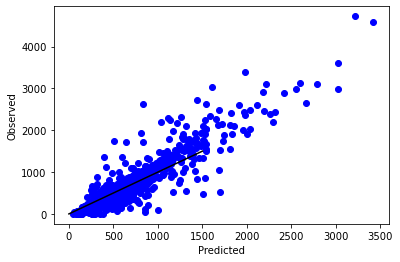

In [12]:
##Running the Combined model on GA data only 
display(xcomb_test)

xxx_ga = combined_df[combined_df['lter'] == 'GA']

ga_xargs = xxx_ga[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', 'tmax', 'tmin',
        'sn_tmax','sn_tmin'
    ]
]

ga_yargs = ga_df1['liveMass']

ga_pred=pipe_comb.predict(ga_xargs)

print('Mean Absolute Error:', metrics.mean_absolute_error(ga_yargs, ga_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ga_yargs, ga_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ga_yargs, ga_pred)))
r_square = metrics.r2_score(ga_yargs, ga_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(ga_yargs, ga_pred))/np.ptp(ga_yargs)))


plt.scatter(ga_pred, ga_yargs, color = 'blue')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 1500], [0, 1500], 'k-')
plt.show()

Mean Absolute Error: 565.3980683013137
Mean Squared Error: 417683.03018818574
Root Mean Squared Error: 646.2840166584547
The r squared is: -2.2996024064065135
-2.2996024064065135
NRMSE is: 0.2540184953693263


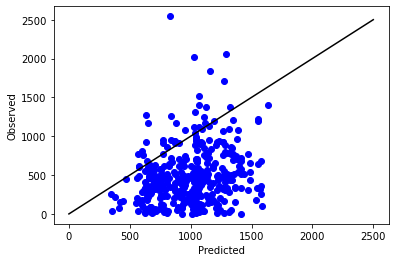

In [4]:
##Running the GA model on VA data

##Really, really needs improvement

va_xargs = va_df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b','wdrvi5', 'savi', 
        'Elevation', 'tmax', 'tmin', 'sn_tmax', 'sn_tmin', 'DOY' 
    ]
]

#removed: 'nd_r_g','dayl','sn_prcp', 'sn_dayl', 'sn_srad', 'sn_vp', 'vp', 'srad', 'prcp'

va_yargs = va_df1['liveMass']

va_pred=pipe.predict(va_xargs)

print('Mean Absolute Error:', metrics.mean_absolute_error(va_yargs, va_pred))
print('Mean Squared Error:', metrics.mean_squared_error(va_yargs, va_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(va_yargs, va_pred)))
r_square = metrics.r2_score(va_yargs, va_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(va_yargs, va_pred))/np.ptp(va_yargs)))


plt.scatter(va_pred, va_yargs, color = 'blue')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 2500], [0, 2500], 'k-')
plt.show()

Mean Absolute Error: 357.50019499710606
Mean Squared Error: 300926.71082847245
Root Mean Squared Error: 548.5678725813902
The r squared is: 0.03252014367890266
0.03252014367890266
NRMSE is: 0.11615015130076102


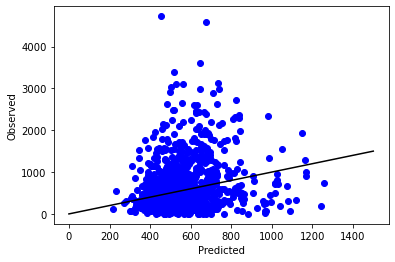

In [5]:
##Running the VA model on GA data

ga_xargs = ga_df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl', 'tmax', 'tmin',
        'srad', 'vp', 'sn_prcp', 'sn_dayl','sn_tmax','sn_tmin','sn_srad','sn_vp', 'DOY'
    ]
]

ga_yargs = ga_df1['Plant_Biomass']

ga_pred=VApipe.predict(ga_xargs)

print('Mean Absolute Error:', metrics.mean_absolute_error(ga_yargs, ga_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ga_yargs, ga_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ga_yargs, ga_pred)))
r_square = metrics.r2_score(ga_yargs, ga_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(ga_yargs, ga_pred))/np.ptp(ga_yargs)))


plt.scatter(ga_pred, ga_yargs, color = 'blue')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 1500], [0, 1500], 'k-')
plt.show()